# Group 3 own experiment

Work flow for this preprocessing:
- Crop the data to only include the experimental part
- Eye ballling the data to exclude obvious bad channels 
- Filtering (high and low pass) 
- ICA
- Artefact detection (rejecting all data that are likely not brain signal)
- Triggers and Epoching
- Downsampling (epochs)
- Plotting single trial epochs
- Plotting evoked plots (averaged epochs)

## 0. Loading modules

In [333]:
# importing packages
import os
import pip
os.system('python -m pip install mne')
os.system('python -m pip install scikit-learn')
import numpy as np
import mne

## 1. Loading in the data

In [335]:
raw = mne.io.read_raw_brainvision("/work/EmmaRisgaardOlsen#9993/Group3_own.vhdr", eog=('EOG1', 'EOG2'), misc='auto', scale=1.0, preload=False, verbose=None)
raw.info['bads']=[]
raw.load_data()

real_raw  = raw.copy() # making a copy

Extracting parameters from /work/EmmaRisgaardOlsen#9993/Group3_own.vhdr...
Setting channel info structure...
Reading 0 ... 751859  =      0.000 ...   751.859 secs...


## 2. Filtering

We now filter the data in order to enhance the signal. We high-pass filter the data at 0.1 Hz and low-pass filter the data at 40 Hz, following the typical practices of EEG preprocessing. 

The high-pass filter minimises slow drifts in the data (e.g. scalp potentials), while the low-pass filter excludes high-frequency noise (e.g. line noise (50 Hz) or EMG (muscle-related artefacts)), with frequencies higher than the frequencies of the signal we are interested in.

Before we run the ICA, an important step is filtering the data to remove low-frequency drifts, which can negatively affect the quality of the ICA fit. The slow drifts are problematic because they reduce the independence of the assumed-to-be-independent sources (e.g., during a slow upward drift, the neural, heartbeat, blink, and other muscular sources will all tend to have higher values), making it harder for the algorithm to find an accurate solution. 

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)

Opening raw-browser...


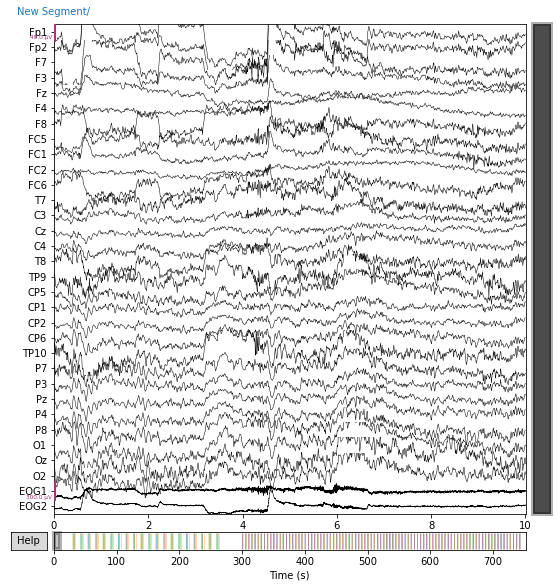

Opening raw-browser...


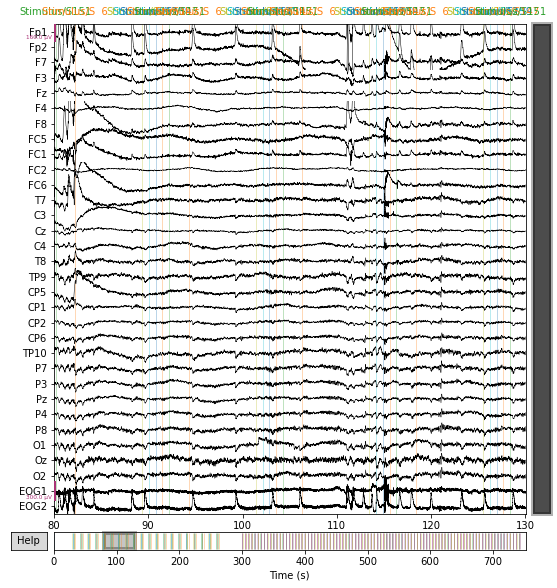

In [336]:
# high-pass filtering the data at 0.1 Hz and subsequently low-pass filtering at 40 Hz
raw = raw.filter(0.1, None) # high-pass filtering
raw = raw.filter(None, 40) # low-pass filtering

# plotting the filtered data for inspection
raw.plot(n_channels=32);
raw.plot(n_channels = 32, scalings = dict(eeg=80e-6, eog=150e-6), start=80, duration = 50);

## 2. Inspecting raw data

In [337]:
raw.load_data()

<RawBrainVision | Group3_own.eeg, 32 x 751860 (751.9 s), ~183.6 MB, data loaded>

## 3. Specify the channel locations using the montage-related functions

In [338]:
montage = mne.channels.make_standard_montage('standard_1020') 
real_raw.set_montage(montage, verbose=False)
raw.set_montage(montage, verbose=False)

<RawBrainVision | Group3_own.eeg, 32 x 751860 (751.9 s), ~183.6 MB, data loaded>

### 4. Redefine the reference to a common average

In [339]:
real_raw.set_eeg_reference('average', projection=False, verbose=False)
raw.set_eeg_reference('average', projection=False, verbose=False)

<RawBrainVision | Group3_own.eeg, 32 x 751860 (751.9 s), ~183.6 MB, data loaded>

## 5. Electrode map 

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


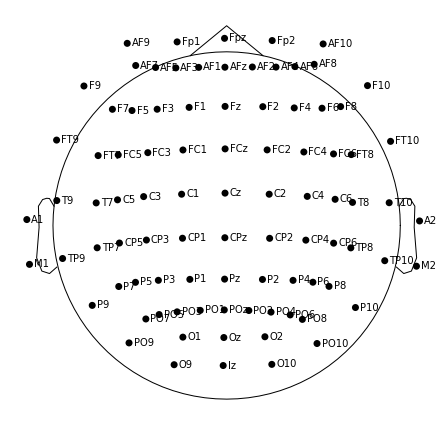

In [340]:
mne.viz.plot_montage(montage, scale_factor=20, show_names=True, kind='topomap', show=True, sphere=None, verbose=None);

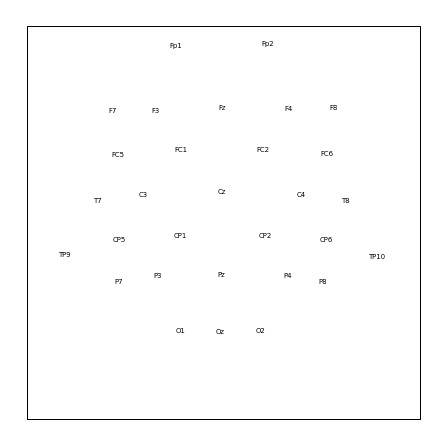

In [341]:
electrodes = mne.channels.make_eeg_layout(raw.info, radius=0.5, width=None, height=None, csd=False)
electrodes.plot();

### 6. Plotting the raw data

We will now plot the raw data to look for any bad channels that should be excluded from our analysis. We use scalings to set the resolution and n_channels to set the number of channels to plot)

Opening raw-browser...


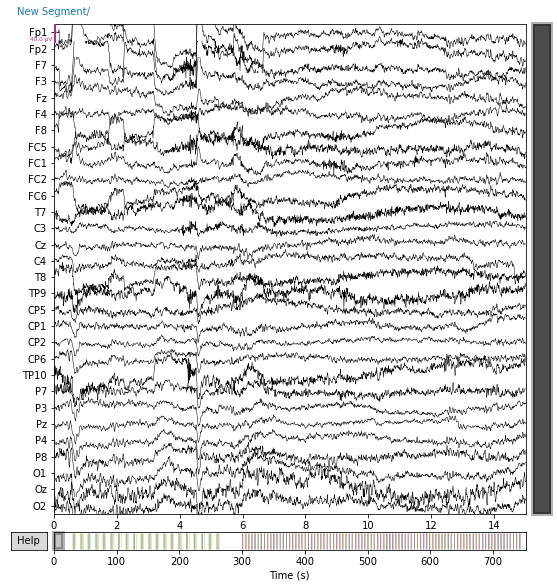

In [342]:
# selecting only EEG and stimulus data & plotting raw data
raw.pick_types(meg=False, eeg=True, stim=True, exclude=[])
raw.plot(n_channels = 30, duration = 15);

Opening raw-browser...


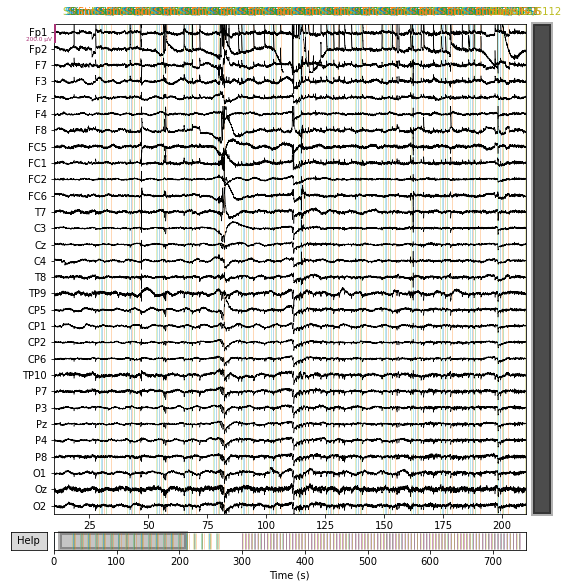

In [343]:
# Trying to plot each channel to see if anyone is bad
# mne.viz.plot_raw(raw, n_channels = 32, scalings = dict(eeg=0.00010), show_first_samp=True, duration = 20);

# Trying to plot each channel to see if anyone is bad
mne.viz.plot_raw(raw, n_channels = 32, scalings = dict(eeg=0.00010), start=10, duration = 200);

Plotting the first 100 seconds of the recognition phase


Opening raw-browser...


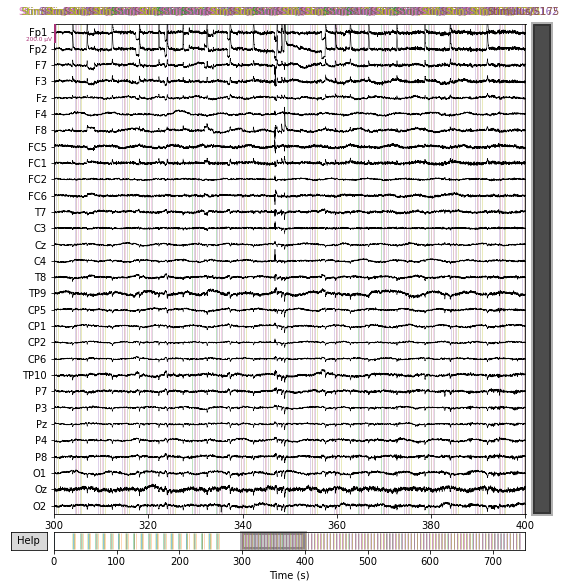

In [320]:
mne.viz.plot_raw(raw, n_channels = 32, scalings = dict(eeg = 1e-4), start = 300, duration = 100); 
# I zoom in the data with "start" and "duration"

Opening raw-browser...


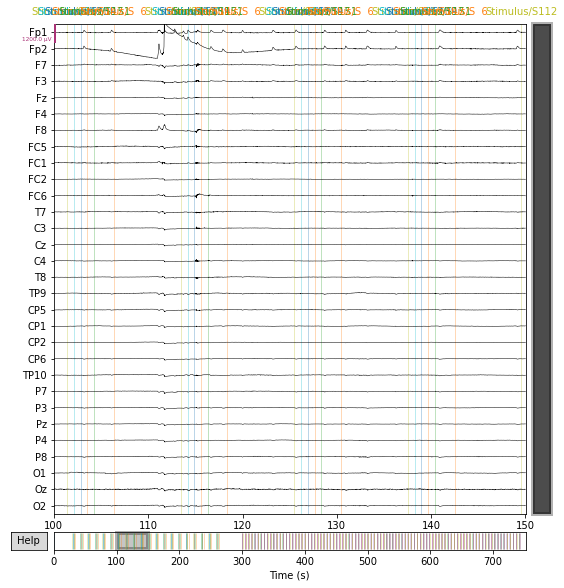

In [321]:
raw.plot(n_channels = 32, scalings = dict(eeg=600e-6, eog=150e-6), start = 100, duration = 50);

Opening raw-browser...


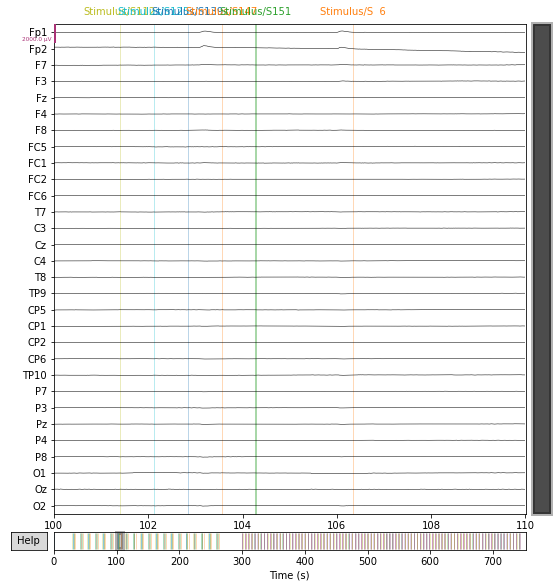

In [322]:
# choosing all channels and scaling (set to auto for now) 
raw.pick_types(meg=False, eeg=True, stim=True)
raw.plot(n_channels = 32, scalings = dict(eeg=100e-5, eog=150e-6), start=100, duration=10);

## ICA - Indpendent Component Analysis

ICA is a method often used doing EEG signal preprocessing. It separates sources that are independent but linearly mixed across sensors. It can be used to filter out/repair artifacs embedded in the signal from the signal without removing the affected data. Before we run the ICA, an important step is filtering the data to remove low-frequency drifts, which can negatively affect the quality of the ICA fit.

In [344]:
ica = mne.preprocessing.ICA(n_components=0.95, random_state=1, max_iter='auto')
ica.fit(raw)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by explained variance: 12 components


/opt/conda/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 263.8s.


<ICA | raw data decomposition, method: fastica (fit in 1000 iterations on 751860 samples), 12 ICA components explaining 95.5 % of variance (30 PCA components available), channel types: eeg, no sources marked for exclusion>

The topo plots shows the scalp map projections of the 14 ICA components. 

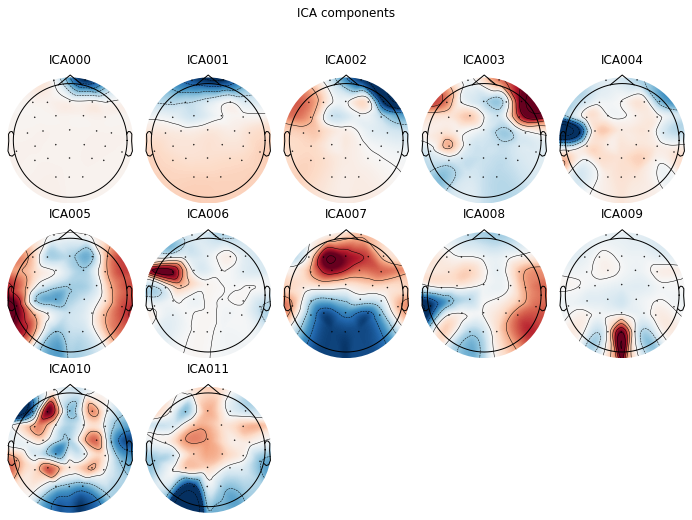

In [345]:
ica.plot_components();

Creating RawArray with float64 data, n_channels=4, n_times=751860
    Range : 0 ... 751859 =      0.000 ...   751.859 secs
Ready.
Opening ica-browser...


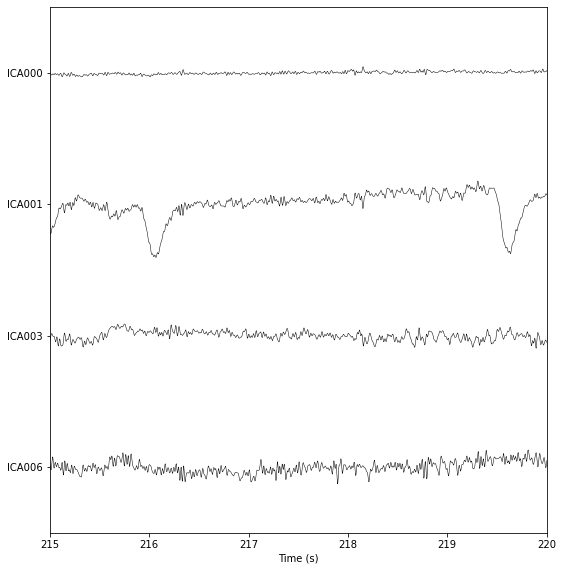

In [346]:
ica.plot_sources(raw, picks = [0,1,3,6], show_scrollbars=False, start = 215, stop = 220); # start = 284, stop = 290

## Excluding component
We remove ICA001 as we can clearly see that it captures eye blinks in the above time series plot. Furthermore, we remove ICA000 as it didn't look very good.


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
375 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


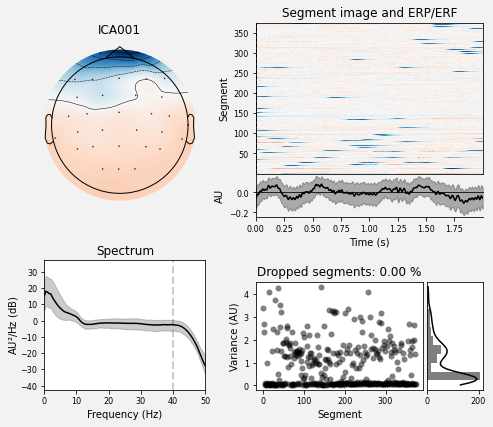

In [347]:
ica.exclude = [1]
ica.plot_properties(raw, picks=ica.exclude);

#ica.plot_properties(raw, picks=ica.exclude,psd_args={'fmax': 35.},image_args={'sigma': 1.})

Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


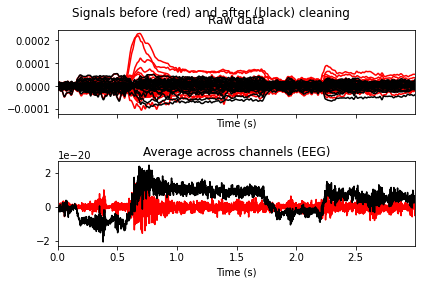

Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Opening raw-browser...


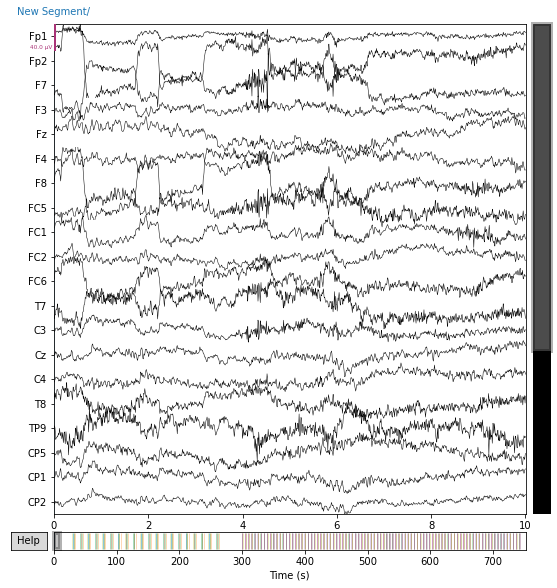

Opening raw-browser...


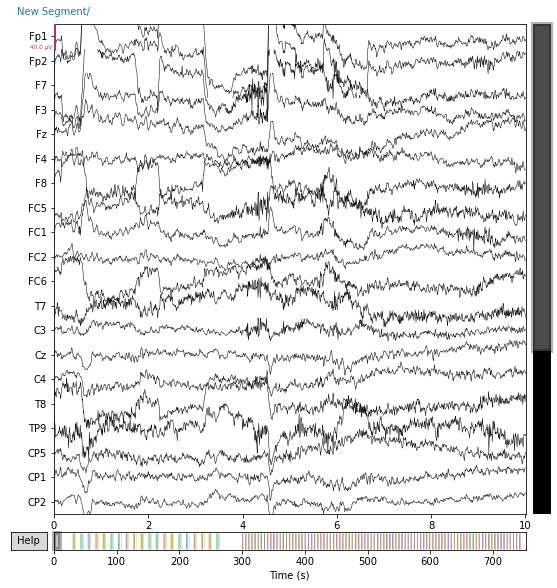

In [348]:
# Seeing how signals would change if we removed component 
ICAcomponents2exclude = [1]
ica.plot_overlay(raw, exclude=ICAcomponents2exclude, picks='eeg')
ica.exclude = ICAcomponents2exclude
reconst_raw = raw.copy()
ica.apply(reconst_raw) # Apply ICA for remove the components
reconst_raw.plot(title='EEG after ICA');
raw.plot(title='EEG before ICA');

# 

In [351]:
ica.apply(real_raw) # applying ICA to the raw signal

Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


<RawBrainVision | Group3_own.eeg, 32 x 751860 (751.9 s), ~183.6 MB, data loaded>

In [352]:
# high-pass filtering the data at 0.1 Hz and subsequently low-pass filtering at 40 Hz
real_raw = real_raw.filter(0.1, None) # high-pass filtering
real_raw = real_raw.filter(None, 40) # low-pass filtering

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



Opening raw-browser...


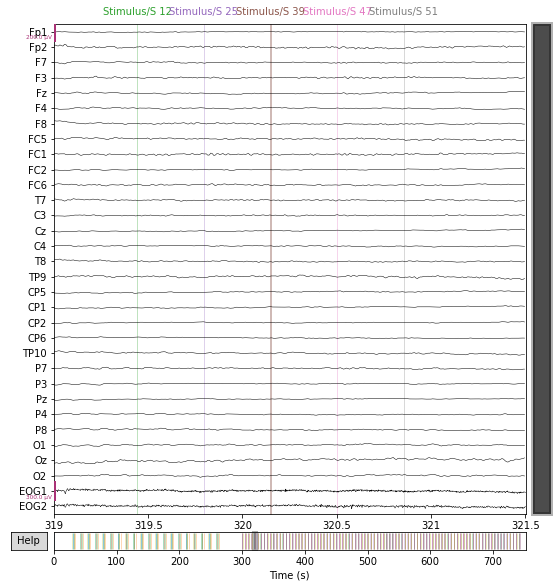

In [353]:
mne.viz.plot_raw(real_raw, n_channels = 32, scalings = dict(eeg = 1e-4), start = 319, duration = 2.5);

## Artefact detection & removal

Selecting a value and reject anything above or below that value. We do this because we determine that values over or under this threshold are liekly not related to brain activity. For now, we just create the variable and then we use it to remove artefacts while epoching.

Opening raw-browser...


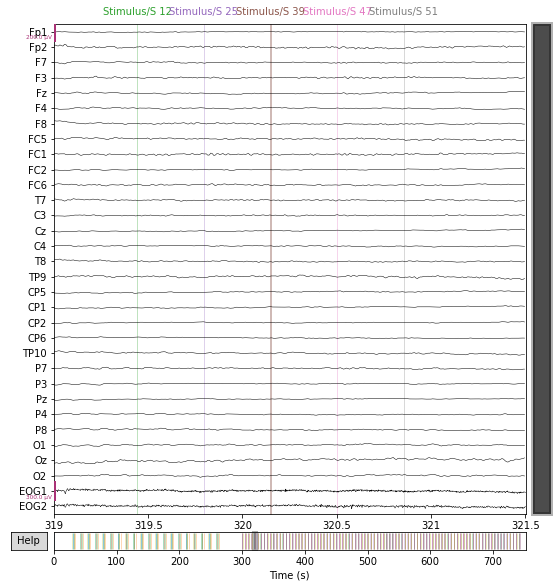

In [354]:
# rejecting everything over or under a threshold of 150 microvolts
# anything above or belove this threshold is likely not brain activity but artefacts
reject = dict(eeg=150e-6)

mne.viz.plot_raw(real_raw, n_channels = 32, scalings = dict(eeg = 1e-4), start = 319, duration = 2.5);

## Epoching

In [355]:
#triggers = mne.events_from_annotations(raw)
triggers, triggers_list = mne.events_from_annotations(real_raw)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  6', 'Stimulus/S 12', 'Stimulus/S 25', 'Stimulus/S 39', 'Stimulus/S 47', 'Stimulus/S 51', 'Stimulus/S112', 'Stimulus/S125', 'Stimulus/S139', 'Stimulus/S147', 'Stimulus/S151', 'Stimulus/S162', 'Stimulus/S175', 'Stimulus/S189', 'Stimulus/S197', 'Stimulus/S201']


In [356]:
# read in trig_list - triggers from logfile
trig_list = np.genfromtxt('/work/58044/Group3/trig_list.csv')

In [357]:
# number of triggers in that list
print(np.shape(trig_list))
# aligning first 10 triggers of both structures
[triggers[0:10,2], trig_list[0:10]]

(571,)


[array([99999,   112,   125,   139,   147,   151,     6,   112,   125,
          139]),
 array([nan,  2.,  5.,  9.,  7.,  1., 99.,  2.,  5.,  9.])]

In [358]:
# making a copy of our trig_list (except 1st nan-trigger) and setting trigger-99 to 6 in order to be able to compare 
# the training-set-triggers directly with our EEG-triggers
trig_list_temp = trig_list[1:].copy()
trig_list_temp = trig_list_temp.astype(int)
trig_list_temp[trig_list_temp==99] = 6
# also a copy of the 3rd column of the triggers-structure (except 1st 99999-trigger)
triggers_temp = triggers[1:,2].copy()
triggers_temp = triggers_temp % 10 # % means modulo - it's an operator that allows you to get the "rest" number after having divided with a given number (here 10)
# comparing the first 10 triggers of both temp-structures
(triggers_temp[0:10], trig_list_temp[0:10])

(array([2, 5, 9, 7, 1, 6, 2, 5, 9, 7]), array([2, 5, 9, 7, 1, 6, 2, 5, 9, 7]))

In [359]:
# getting the index of the first trigger that's not part of the learning phase (and we start from index 1 because or temp-structures don't include the first pseudo-trial)
learn_phase = np.argmax((triggers[1:,2]>151) | (triggers[1:,2]<112) & (triggers[1:,2]!=6))
# testing whether all triggers of the two vectors correspond from the beginning till then
all(triggers_temp[0:learn_phase]==trig_list_temp[0:learn_phase])

True

In [360]:
# THIS IS THE CRUCIAL STEP in creating and adapted triggers-structure:
# the logic is that for any values AFTER the learning phase, we simply subtract the modulo-values in triggers-temp from the triggers
# (cuz the trigger-temp-values are equivalent to the "ones" from the triggers-structure), and then we add the values from the logfile
new_triggers = triggers.copy()
new_triggers[learn_phase+1:,2] = new_triggers[learn_phase+1:,2]-triggers_temp[learn_phase:]+trig_list_temp[learn_phase:]

In [361]:
new_triggers[:,2] # just having a quick look at the "new" trigger-values

array([99999,   112,   125,   139,   147,   151,     6,   112,   125,
         139,   147,   151,     6,   112,   125,   139,   147,   151,
           6,   112,   125,   139,   147,   151,     6,   112,   125,
         139,   147,   151,     6,   112,   125,   139,   147,   151,
           6,   112,   125,   139,   147,   151,     6,   112,   125,
         139,   147,   151,     6,   112,   125,   139,   147,   151,
           6,   112,   125,   139,   147,   151,     6,   112,   125,
         139,   147,   151,     6,   112,   125,   139,   147,   151,
           6,   112,   125,   139,   147,   151,     6,   112,   125,
         139,   147,   151,     6,   112,   125,   139,   147,   151,
           6,   112,   125,   139,   147,   151,     6,   112,   125,
         139,   147,   151,     6,   112,   125,   139,   147,   151,
           6,   112,   125,   139,   147,   151,     6,   112,   125,
         139,   147,   151,     6,   162,   177,   183,   195,   206,
         162,   178,

In [362]:
# THIS IS WHERE WE RECODE THE TRIGGERS
# Now we want to be able to tell all the different incorrect sequences from each other
# And we know that they ALL uniquely start with 162 (cuz that's always the first number in an incrorrect sequence)
# And we also know that if the second trigger is 175 and third is not 189, then it's a sequence that is incorrect from its third place onwards (and then we add 50 to all triggers in those sequences)
# Same logic if the second and third triggers are 175 and 189, resp., and fourth is not 197, then it's a sequence that it's incorrect from its fourth place onwards (we add 100 to those)
# Same logic if the second to fourth triggers are 175, 189, 197 resp., and fifth is not 201, then it's a sequence that it's incorrect from its fifth place onwards (we add 150 to those)
incorr_idx = new_triggers[:,2] == 162 # getting a boolean index
incorr_rows = [i for i, x in enumerate(incorr_idx) if x] # getting the actual trial-numbers to have something to loop over
print(len(incorr_rows))
for i in incorr_rows:
    if (new_triggers[i+1,2]==175) & (new_triggers[i+2,2]!=189):
        #print('third')
        new_triggers[i:i+5,2] = new_triggers[i:i+5,2]+50
    elif (new_triggers[i+1,2]==175) & (new_triggers[i+2,2]==189) & (new_triggers[i+3,2]!=197):
        #print('fourth')
        new_triggers[i:i+5,2] = new_triggers[i:i+5,2]+100
    elif (new_triggers[i+1,2]==175) & (new_triggers[i+2,2]==189) & (new_triggers[i+3,2]==197) & (new_triggers[i+4,2]!=201):
        #print('fifth')
        new_triggers[i:i+5,2] = new_triggers[i:i+5,2]+150

59


In [363]:
np.unique(new_triggers[:,2]) # checking how many unique triggers we need to create event_ids for

array([    6,    12,    25,    39,    47,    51,   112,   125,   139,
         147,   151,   162,   171,   173,   174,   176,   177,   178,
         179,   181,   183,   184,   185,   186,   187,   188,   189,
         191,   193,   195,   196,   197,   198,   199,   201,   203,
         204,   205,   206,   207,   208,   209,   212,   225,   231,
         234,   236,   247,   248,   253,   259,   262,   275,   289,
         290,   291,   293,   294,   296,   298,   301,   303,   304,
         306,   307,   308,   312,   325,   339,   347,   353,   354,
         356, 99999])

In [364]:
new_event_id = {
 'Imagine': 6, # "Imagine"
 'recog_phase/corr/first/2': 12, # Number 1, recognition phase | correct
 'recog_phase/corr/second/5': 25, # Number 2, recognition phase | correct
 'recog_phase/corr/third/9': 39, # Number 3, recognition phase | correct
 'recog_phase/corr/fourth/7': 47, # Number 4, recognition phase | correct
 'recog_phase/corr/fifth/1': 51, # Number 5, recognition phase | correct
 'learn_phase/first/2': 112, # Number 1, learning phase
 'learn_phase/second/5': 125, # Number 2, learning phase
 'learn_phase/third/9': 139, # Number 3, learning phase
 'learn_phase/fourth/7': 147, # Number 4, learning phase
 'learn_phase/fifth/1': 151, # Number 5, learning phase
 'recog_phase/incorr2/first/2': 162, # Number 1, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/1': 171, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/3': 173, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/4': 174, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/6': 176, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/7': 177, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/8': 178, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/second/9': 179, # Number 2, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/1': 181, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/3': 183, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/4': 184, # Number 3, recognition phase | incorrect in place 2 
 'recog_phase/incorr2/third/5': 185, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/6': 186, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/7': 187, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/8': 188, # Number 3, recognition phase | incorrect in place 2
 'recog_phase/incorr2/third/9': 189, # Number 3, recognition phase | incorrect in place 2 
 'recog_phase/incorr2/fourth/1': 191, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/3': 193, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/5': 195, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/6': 196, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/7': 197, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/8': 198, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fourth/9': 199, # Number 4, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/1': 201, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/3': 203, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/4': 204, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/5': 205, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/6': 206, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/7': 207, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/8': 208, # Number 5, recognition phase | incorrect in place 2
 'recog_phase/incorr2/fifth/9': 209, # Number 5, recognition phase | incorrect in place 2

 'recog_phase/incorr2/first/2': 212, # Number 1, recognition phase | incorrect in place 3
 'recog_phase/incorr2/second/5': 225, # Number 2, recognition phase | incorrect in place 3
 'recog_phase/incorr2/third/1': 231, # Number 3, recognition phase | incorrect in place 3
 'recog_phase/incorr2/third/4': 234, # Number 3, recognition phase | incorrect in place 3
 'recog_phase/incorr2/third/6': 236, # Number 3, recognition phase | incorrect in place 3
 'recog_phase/incorr2/fourth/7': 247, # Number 4, recognition phase | incorrect in place 3
 'recog_phase/incorr2/fourth/8': 248, # Number 4, recognition phase | incorrect in place 3
 'recog_phase/incorr2/fifth/3': 253, # Number 5, recognition phase | incorrect in place 3
 'recog_phase/incorr2/fifth/9': 259, # Number 5, recognition phase | incorrect in place 3
 
 'recog_phase/incorr4/first/2': 262, # Number 1, recognition phase | incorrect in place 4
 'recog_phase/incorr4/second/5': 275, # Number 2, recognition phase | incorrect in place 4
 'recog_phase/incorr4/third/9': 289, # Number 3, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/0': 290, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/1': 291, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/3': 293, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/4': 294, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/6': 296, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fourth/8': 298, # Number 4, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/1': 301, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/3': 303, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/4': 304, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/6': 306, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/7': 307, # Number 5, recognition phase | incorrect in place 4
 'recog_phase/incorr4/fifth/8': 308, # Number 5, recognition phase | incorrect in place 4
 
 'recog_phase/incorr4/first/2': 312, # Number 1, recognition phase | incorrect in place 5
 'recog_phase/incorr4/second/5': 325, # Number 2, recognition phase | incorrect in place 5
 'recog_phase/incorr4/third/9': 339, # Number 3, recognition phase | incorrect in place 5
 'recog_phase/incorr4/fourth/7': 347, # Number 4, recognition phase | incorrect in place 5
 'recog_phase/incorr4/fifth/3': 353, # Number 5, recognition phase | incorrect in place 5
 'recog_phase/incorr4/fifth/4': 354, # Number 5, recognition phase | incorrect in place 5
 'recog_phase/incorr4/fifth/6': 356, # Number 5, recognition phase | incorrect in place 5
 }


/tmp/ipykernel_48/2902320468.py:2: RuntimeWarning: event 162 missing from event_id will be ignored
  mne.viz.plot_events(new_triggers[:,:], sfreq=250, first_samp=real_raw.first_samp, event_id=new_event_id);
/tmp/ipykernel_48/2902320468.py:2: RuntimeWarning: event 181 missing from event_id will be ignored
  mne.viz.plot_events(new_triggers[:,:], sfreq=250, first_samp=real_raw.first_samp, event_id=new_event_id);
/tmp/ipykernel_48/2902320468.py:2: RuntimeWarning: event 184 missing from event_id will be ignored
  mne.viz.plot_events(new_triggers[:,:], sfreq=250, first_samp=real_raw.first_samp, event_id=new_event_id);
/tmp/ipykernel_48/2902320468.py:2: RuntimeWarning: event 186 missing from event_id will be ignored
  mne.viz.plot_events(new_triggers[:,:], sfreq=250, first_samp=real_raw.first_samp, event_id=new_event_id);
/tmp/ipykernel_48/2902320468.py:2: RuntimeWarning: event 197 missing from event_id will be ignored
  mne.viz.plot_events(new_triggers[:,:], sfreq=250, first_samp=real_raw.f

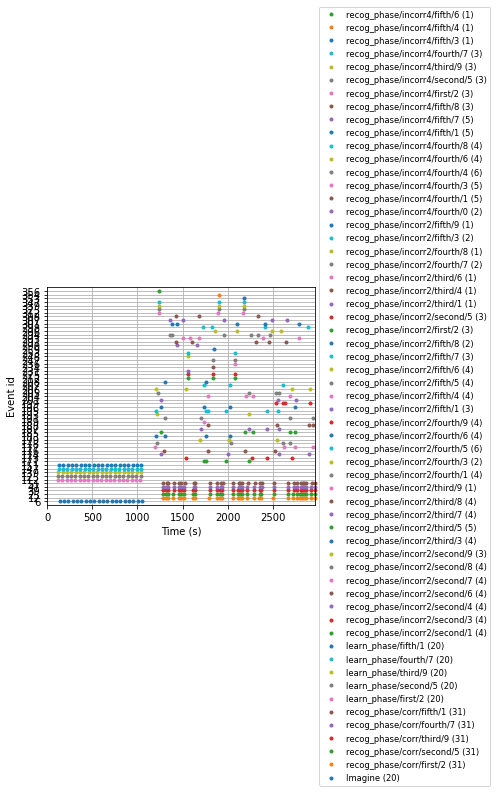

In [365]:
# plotting the events
mne.viz.plot_events(new_triggers[:,:], sfreq=250, first_samp=real_raw.first_samp, event_id=new_event_id);

## Downsampling

## 8. ERPs

The time window we establish span from 0.2 seconds before stimulus onset to 0.5 seconds after stimulus onset. The 200 milliseconds before the onset of the stimulus enables us to examine a baseline of activity without stimulus presentation. The 500 milliseconds after the stimulus onset denote the time in which we expect the effect to occur, since most EEG components arise before the 500 milliseconds mark.

In [366]:
# establishing time window
tmin, tmax = -0.2, 0.5

# choosing only EEG channels for epoching
picks = mne.pick_types(real_raw.info, meg=False, eeg=True, eog=False)

In [367]:
# creating the epochs using the variables created in the cell above, and timelocking to the events
# baseline time interval spans from beginning of the data (-0.2 s) to 0 s (stimulus onset)
# we use the reject variable we created earlier in order to remove artefacts (everything below or above 150 mv is most likely not brain activity)
epochs = mne.Epochs(real_raw, new_triggers[:,:], new_event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)

Not setting metadata
429 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 429 events and 701 original time points ...
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F3', 'F8', 'FC5', 'FC1', 'FC6', 'T7', 'CP5', 'P7', 'O1', 'Oz']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['Fp2', 'F7', 'F8', 'FC5', 'FC6', 'C4']
    Rejecting  epoch based on EEG : ['Fp2']
    Rejecting  epoch based on EEG : ['F7', 'F3', 'F8', 'FC5', 'FC6', 'T7', 'C3', 'C4', 'T8']
    Rejecting  epoch based on EEG : ['Fp2', 'F8']
    Rejecting  epoch based on EEG : ['Fp2', 'F8']
    Rejecting  epoch based on EEG : ['Fp2', 'F7', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'FC5', 'FC6', 'C4']
11 bad epochs dropped


As you can see, we are dropping some epochs that were deeemed 'bad' because they contain values over or under the threshold we defined, allowing us to exclude epochs with artefacts.

## Downsampling
Now we reduce the sample-rate to 250 Hz instead of 600. We do this after epoching, since downsampling before epoching can potentially mess with the precision of the extraction of epochs.

In [368]:
# downsampling to 250 Hz
epochs_resampled = epochs.resample(250)

## ERPs
Now we can group the epochs by the place the sequence was broken. So we distinguish between "sequence wrong at digit nr. 3" and "sequence wrong at digit nr. 5". We expect differences in ERP as we expect expactations to build up and therefore the surprise being "higher" when the sequence is broken at the 5th place in the sequence.

In [369]:
incorr2 = epochs_resampled['recog_phase/incorr2/second']
incorr4 = epochs_resampled['recog_phase/incorr4/fourth']
corr = epochs_resampled['recog_phase/corr']

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


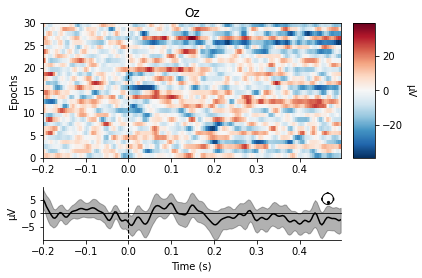

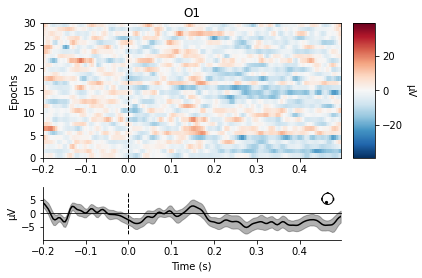

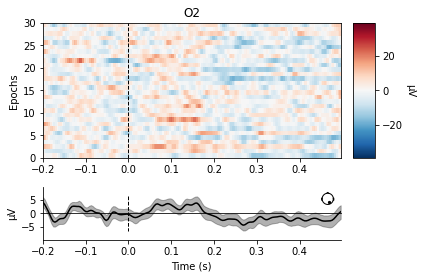

Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


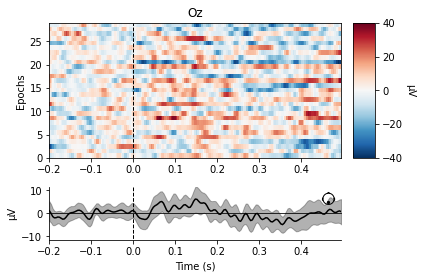

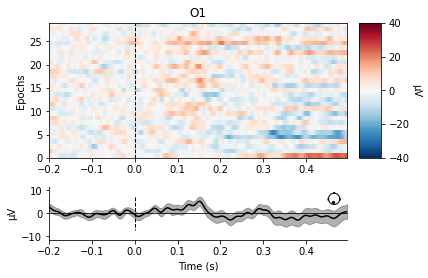

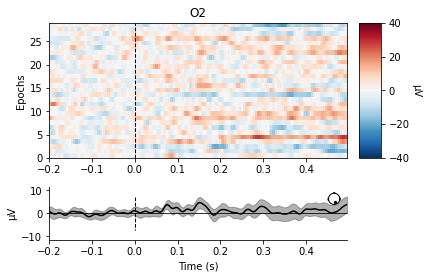

Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


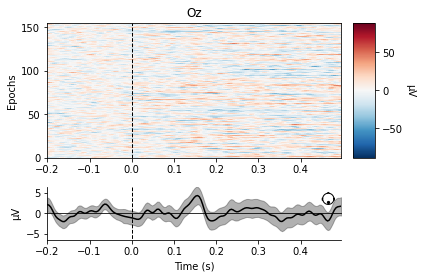

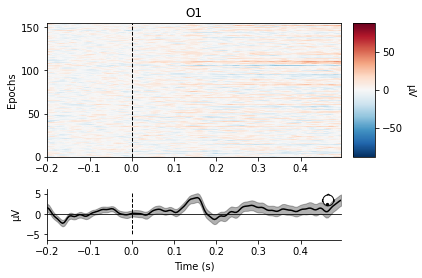

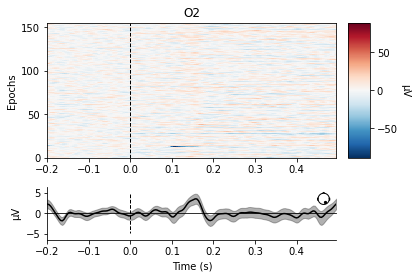

In [370]:
# plotting one channel as an example for each modality
incorr2.plot_image(picks=['Oz','O1','O2']);
incorr4.plot_image(picks=['Oz','O1','O2']);
corr.plot_image(picks=['Oz','O1','O2']);

## Now averaging epochs

### Plot: incorr 3 vs incorr 5

In [378]:
# creating evokeds for incorrect sequence at 3rd digit by averaging over epochs
incorr2_evoked = incorr2.average()

# creating evokeds for incorrect sequence at 5th digit by averaging over epochs
incorr4_evoked = incorr4.average()

corr_evoked = corr.average()

all_evoked = dict(incorr2 = incorr2_evoked, incorr4 = incorr4_evoked, corr=corr_evoked)

In [372]:
# Saving evoked triggers as fif file for the later analysis
incorr2_evoked.save("/work/EmmaRisgaardOlsen#9993/fif_files/incorr2_evoked.fif",overwrite=True)
incorr4_evoked.save("/work/EmmaRisgaardOlsen#9993/fif_files/incorr4_evoked.fif",overwrite=True)
corr_evoked.save("/work/EmmaRisgaardOlsen#9993/fif_files/corr_evoked.fif",overwrite=True)

epochs_resampled.save("/work/EmmaRisgaardOlsen#9993/fif_files/epochs.fif",overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


/tmp/ipykernel_48/2551702719.py:2: RuntimeWarning: This filename (/work/EmmaRisgaardOlsen#9993/fif_files/incorr2_evoked.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  incorr2_evoked.save("/work/EmmaRisgaardOlsen#9993/fif_files/incorr2_evoked.fif",overwrite=True)
/tmp/ipykernel_48/2551702719.py:3: RuntimeWarning: This filename (/work/EmmaRisgaardOlsen#9993/fif_files/incorr4_evoked.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  incorr4_evoked.save("/work/EmmaRisgaardOlsen#9993/fif_files/incorr4_evoked.fif",overwrite=True)
/tmp/ipykernel_48/2551702719.py:4: RuntimeWarning: This filename (/work/EmmaRisgaardOlsen#9993/fif_files/corr_evoked.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  corr_evoked.save("/work/EmmaRisgaardOlsen#9993/fif_files/c

No projector specified for this dataset. Please consider the method self.add_proj.


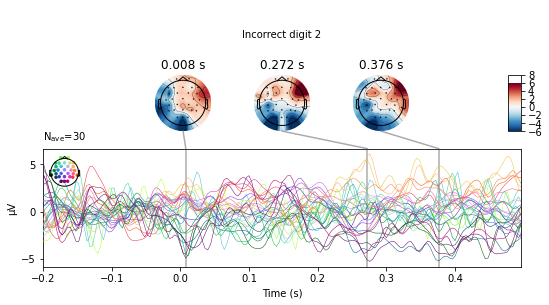

No projector specified for this dataset. Please consider the method self.add_proj.


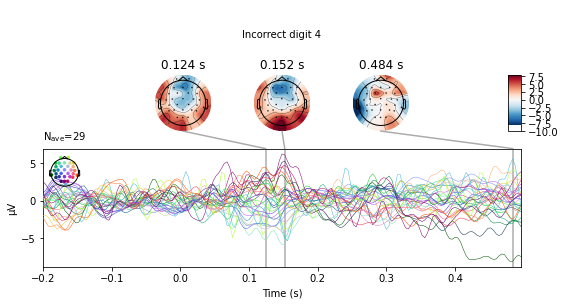

No projector specified for this dataset. Please consider the method self.add_proj.


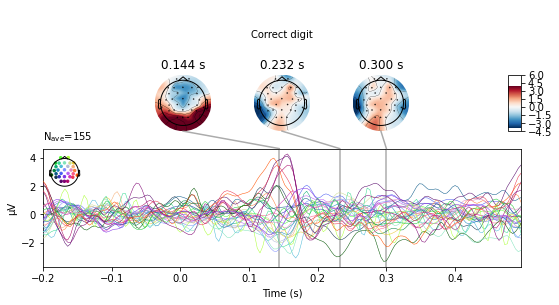

In [373]:
incorr2_plot = incorr2_evoked.plot_joint(picks='eeg', title = "Incorrect digit 2");
incorr4_plot = incorr4_evoked.plot_joint(picks='eeg', title = "Incorrect digit 4");
corr_plot = corr_evoked.plot_joint(picks='eeg', title = "Correct digit");

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


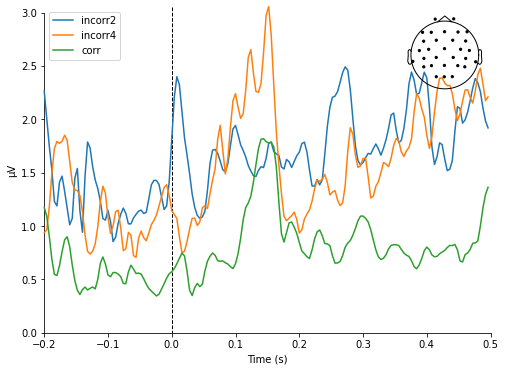

[<Figure size 576x432 with 2 Axes>]

In [374]:
mne.viz.plot_compare_evokeds(dict(incorr2=incorr2_evoked, incorr4=incorr4_evoked,corr=corr_evoked),
                             legend='upper left', show_sensors='upper right')

In [187]:
# N100 or N1 wave
# A negative deflection peaking between 90 and 200 msec
#after the onset of stimulus,
#is observed when an unexpected stimulus is presented. 
# It is an orienting response or a “matching process,”
# that is, whenever a stimulus is presented, 
# it is matched with previously experienced stimuli. 
# It has maximum amplitude over Cz and is therefore also
# called “vertex potential.”
# It is elicited by any unpredictable stimulus in the absence of task demands?;

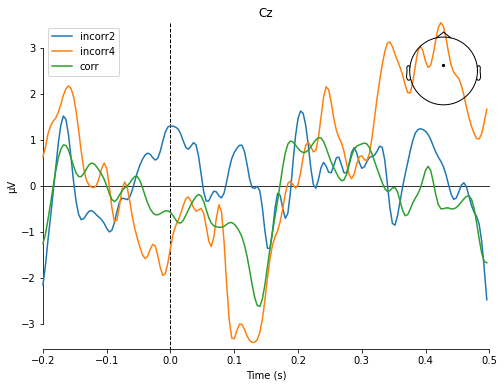

In [379]:
# decision making potential P300
Cz_evoked_plot = mne.viz.plot_compare_evokeds(all_evoked, picks='Cz')
Cz_evoked_plot
Cz_evoked_plot[0].savefig(fname = "Cz_evoked_plot")

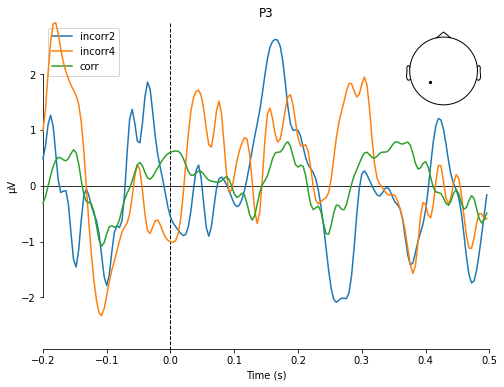

In [381]:
# decision making potential P300
p3_evoked_plot = mne.viz.plot_compare_evokeds(all_evoked, picks='P3')
p3_evoked_plot
p3_evoked_plot[0].savefig(fname = "p3_evoked_plot")

In [ ]:
## Extra

Combining evoked objects to show contrasts. For this, we use the mne.combine_evoked function. 

We generate a simple difference by passing weights=[1, -1]. Then we plot the difference wave at each sensor using plot_topo:

In [382]:
evoked_diff = mne.combine_evoked([incorr2_evoked, incorr4_evoked,corr_evoked], weights=[1, -1])
evoked_diff.pick_types(meg=False).plot_topo(color='r', legend=False)

ValueError: weights must be the same size as all_evoked